# Non-Cooperative Bidding Game

### By Heider Jeffer

In [2]:
import itertools
import numpy as np
import random
import matplotlib.pyplot as plt

# Game definition
class BiddingGame:
    def __init__(self, players, bids, profits):
        self.players = players
        self.bids = bids
        self.profits = profits
        
    def play_round(self, bid_choices):
        min_bid = min(bid_choices.values())
        winners = [p for p, b in bid_choices.items() if b == min_bid]
        profit_each = self.profits.get((winners[0], min_bid), 0) / len(winners)
        return {p: (profit_each if p in winners else 0) for p in self.players}
    
    def all_bid_profiles(self):
        return list(itertools.product(self.bids, repeat=len(self.players)))
    
    def find_nash_equilibria(self):
        equilibria = []
        for profile in self.all_bid_profiles():
            stable = True
            profile_dict = dict(zip(self.players, profile))
            payoffs = self.play_round(profile_dict)
            
            for i, player in enumerate(self.players):
                current_bid = profile[i]
                current_payoff = payoffs[player]
                for alt_bid in self.bids:
                    if alt_bid == current_bid:
                        continue
                    alt_profile = list(profile)
                    alt_profile[i] = alt_bid
                    alt_profile_dict = dict(zip(self.players, alt_profile))
                    alt_payoffs = self.play_round(alt_profile_dict)
                    if alt_payoffs[player] > current_payoff:
                        stable = False
                        break
                if not stable:
                    break
            if stable:
                equilibria.append(profile)
        return equilibria


In [3]:
players = ['Firm A', 'Firm B', 'Firm C']
bids = [100, 110, 120, 130]
profits = {
    ('Firm A', 100): 10, ('Firm A', 110): 15, ('Firm A', 120): 20, ('Firm A', 130): 25,
    ('Firm B', 100): 9,  ('Firm B', 110): 14, ('Firm B', 120): 19, ('Firm B', 130): 24,
    ('Firm C', 100): 11, ('Firm C', 110): 16, ('Firm C', 120): 21, ('Firm C', 130): 26,
}

game = BiddingGame(players, bids, profits)
nash_equilibria = game.find_nash_equilibria()

print("Pure Strategy Nash Equilibria:")
for eq in nash_equilibria:
    print(eq)


Pure Strategy Nash Equilibria:
(100, 100, 100)


#  Repeated Game with Q-learning Strategy

In [4]:
# Repeated Game with Q-learning Strategy

class QLearningBiddingGame(BiddingGame):
    def __init__(self, players, bids, profits, rounds=50, alpha=0.3, gamma=0.9, epsilon=0.2):
        super().__init__(players, bids, profits)
        self.rounds = rounds
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = {p: {b: 0 for b in bids} for p in players}
        self.history = []
        
    def choose_bid(self, player):
        if random.random() < self.epsilon:
            return random.choice(self.bids)
        max_q = max(self.Q[player].values())
        best_bids = [b for b, q in self.Q[player].items() if q == max_q]
        return random.choice(best_bids)
    
    def update_q(self, player, bid, reward, next_max):
        old_q = self.Q[player][bid]
        self.Q[player][bid] = old_q + self.alpha * (reward + self.gamma * next_max - old_q)
    
    def simulate(self):
        current_bids = {p: random.choice(self.bids) for p in self.players}
        for r in range(1, self.rounds + 1):
            profits = self.play_round(current_bids)
            self.history.append((r, current_bids.copy(), profits.copy()))
            for p in self.players:
                b = current_bids[p]
                reward = profits[p]
                next_max = max(self.Q[p].values())
                self.update_q(p, b, reward, next_max)
            current_bids = {p: self.choose_bid(p) for p in self.players}
        return self.history


In [5]:
qgame = QLearningBiddingGame(players, bids, profits, rounds=50)
history = qgame.simulate()

# Print last few rounds
for round_num, bids_chosen, profits_earned in history[-5:]:
    print(f"Round {round_num}: Bids = {bids_chosen}, Profits = {profits_earned}")


Round 46: Bids = {'Firm A': 100, 'Firm B': 100, 'Firm C': 100}, Profits = {'Firm A': 3.3333333333333335, 'Firm B': 3.3333333333333335, 'Firm C': 3.3333333333333335}
Round 47: Bids = {'Firm A': 100, 'Firm B': 100, 'Firm C': 100}, Profits = {'Firm A': 3.3333333333333335, 'Firm B': 3.3333333333333335, 'Firm C': 3.3333333333333335}
Round 48: Bids = {'Firm A': 100, 'Firm B': 100, 'Firm C': 130}, Profits = {'Firm A': 5.0, 'Firm B': 5.0, 'Firm C': 0}
Round 49: Bids = {'Firm A': 100, 'Firm B': 100, 'Firm C': 100}, Profits = {'Firm A': 3.3333333333333335, 'Firm B': 3.3333333333333335, 'Firm C': 3.3333333333333335}
Round 50: Bids = {'Firm A': 100, 'Firm B': 100, 'Firm C': 110}, Profits = {'Firm A': 5.0, 'Firm B': 5.0, 'Firm C': 0}


# Visualize bid evolution

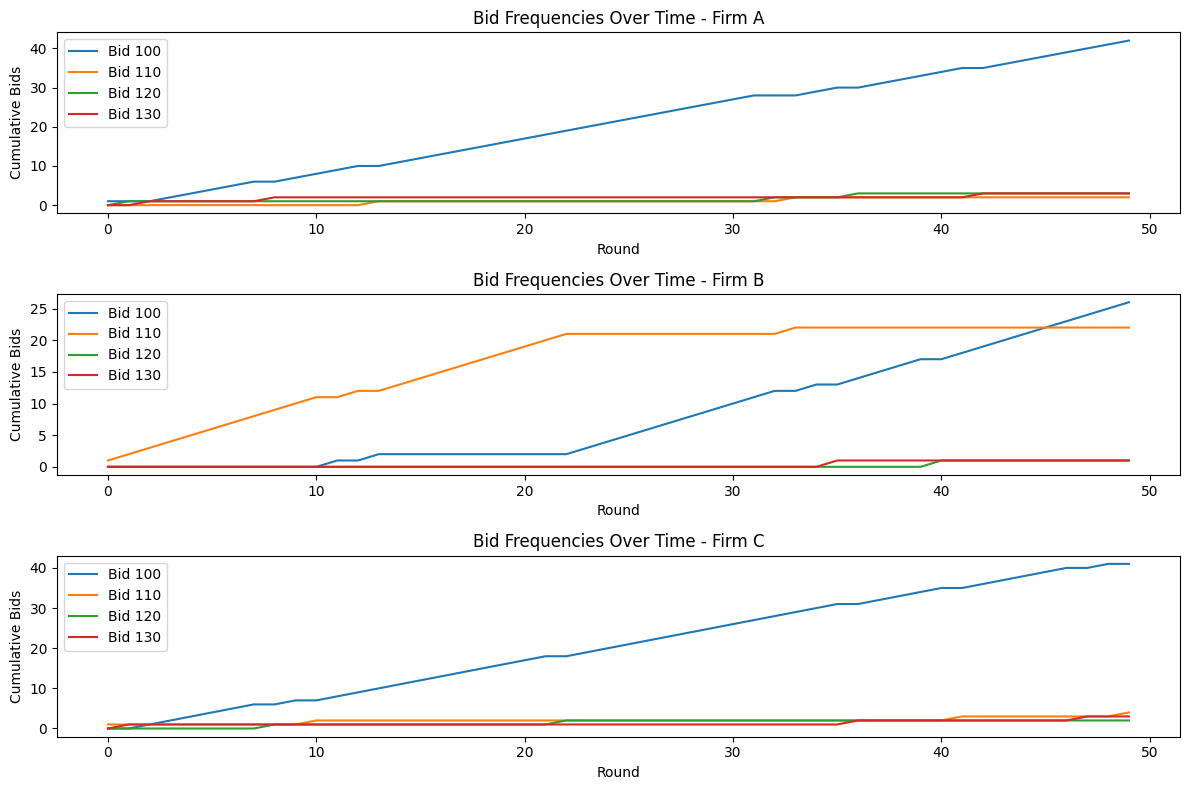

In [6]:
# Visualize bid evolution
bid_counts = {p: {b: [] for b in bids} for p in players}

for _, bids_chosen, _ in history:
    for p in players:
        for b in bids:
            count = 1 if bids_chosen[p] == b else 0
            bid_counts[p][b].append(count)

plt.figure(figsize=(12, 8))
for i, p in enumerate(players, 1):
    plt.subplot(3, 1, i)
    for b in bids:
        cum_freq = np.cumsum(bid_counts[p][b])
        plt.plot(cum_freq, label=f'Bid {b}')
    plt.title(f'Bid Frequencies Over Time - {p}')
    plt.xlabel('Round')
    plt.ylabel('Cumulative Bids')
    plt.legend()
plt.tight_layout()
plt.show()


 # Cooperative Game: Shapley Value for Cost Sharing

In [7]:
import math  # Add this import at the top

def powerset(s):
    return [set(c) for r in range(1, len(s)+1) for c in itertools.combinations(s, r)]

class CostSharingGame:
    def __init__(self, players, cost_function):
        self.players = set(players)
        self.cost_function = cost_function

    def shapley_value(self):
        n = len(self.players)
        values = {p: 0 for p in self.players}
        for player in self.players:
            for coalition in powerset(self.players - {player}):
                c = frozenset(coalition)
                c_with = frozenset(coalition | {player})
                weight = (math.factorial(len(coalition)) * math.factorial(n - len(coalition) - 1)) / math.factorial(n)
                marginal = self.cost_function[c_with] - self.cost_function.get(c, 0)
                values[player] += weight * marginal
        return values



In [8]:
players_coop = {'A', 'B', 'C'}
costs = {
    frozenset({'A'}): 120,
    frozenset({'B'}): 150,
    frozenset({'C'}): 100,
    frozenset({'A', 'B'}): 200,
    frozenset({'A', 'C'}): 190,
    frozenset({'B', 'C'}): 210,
    frozenset({'A', 'B', 'C'}): 270,
}

coop_game = CostSharingGame(players_coop, costs)
shapley_vals = coop_game.shapley_value()

print("Shapley Value Allocations:")
for player, value in shapley_vals.items():
    print(f"Retailer {player}: {value:.2f}")


Shapley Value Allocations:
Retailer B: 58.33
Retailer C: 45.00
Retailer A: 43.33


# Example with 4 Players (A, B, C, D)

In [10]:
players_coop = {'A', 'B', 'C', 'D'}

costs = {
    frozenset({'A'}): 100,
    frozenset({'B'}): 120,
    frozenset({'C'}): 90,
    frozenset({'D'}): 80,
    frozenset({'A', 'B'}): 180,
    frozenset({'A', 'C'}): 160,
    frozenset({'A', 'D'}): 150,
    frozenset({'B', 'C'}): 170,
    frozenset({'B', 'D'}): 160,
    frozenset({'C', 'D'}): 140,
    frozenset({'A', 'B', 'C'}): 240,
    frozenset({'A', 'B', 'D'}): 230,
    frozenset({'A', 'C', 'D'}): 220,
    frozenset({'B', 'C', 'D'}): 210,
    frozenset({'A', 'B', 'C', 'D'}): 280,
}

coop_game = CostSharingGame(players_coop, costs)
shapley_vals = coop_game.shapley_value()

print("Shapley Value Allocations:")
for player, value in shapley_vals.items():
    print(f"Player {player}: {value:.2f}")


Shapley Value Allocations:
Player B: 54.17
Player C: 41.67
Player A: 52.50
Player D: 34.17


# Auto-generate coalition costs

In [11]:
import itertools
import random

def generate_coalition_costs(players, base_costs, synergy=10):
    """
    Generate cost for every coalition using a synergy factor.
    Larger coalitions are cheaper due to cost-sharing.
    """
    costs = {}
    for r in range(1, len(players) + 1):
        for coalition in itertools.combinations(players, r):
            coalition_set = frozenset(coalition)
            size = len(coalition)
            total = sum(base_costs[p] for p in coalition)
            cost = total - synergy * (size - 1)  # synergy reduces total cost
            costs[coalition_set] = round(cost, 2)
    return costs


# Shapley value run

In [13]:
players = ['A', 'B', 'C', 'D', 'E']
base_costs = {p: random.randint(80, 120) for p in players}
costs = generate_coalition_costs(players, base_costs, synergy=15)

coop_game = CostSharingGame(players, costs)
shapley_vals = coop_game.shapley_value()

print("Base Costs:", base_costs)
print("\nShapley Value Allocations:")
for player, value in shapley_vals.items():
    print(f"Player {player}: {value:.2f}")


Base Costs: {'A': 119, 'B': 101, 'C': 80, 'D': 102, 'E': 83}

Shapley Value Allocations:
Player C: 52.00
Player A: 83.20
Player B: 68.80
Player E: 54.40
Player D: 69.60


# Visualize Shapley Values

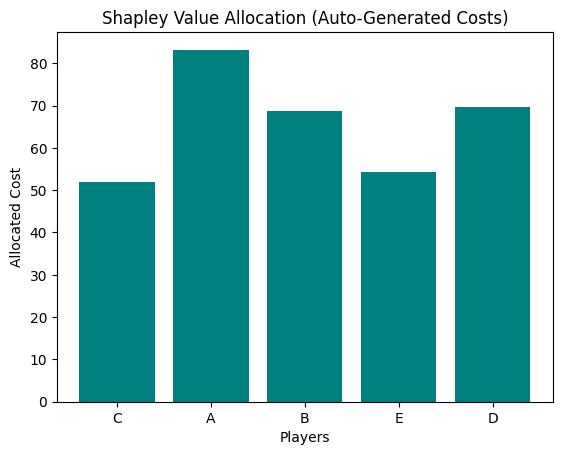

In [15]:
import matplotlib.pyplot as plt

plt.bar(shapley_vals.keys(), shapley_vals.values(), color='teal')
plt.title("Shapley Value Allocation (Auto-Generated Costs)")
plt.ylabel("Allocated Cost")
plt.xlabel("Players")
plt.show()
